### Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.optim.lr_scheduler import _LRScheduler
from torchvision.utils import save_image
from torchvision.utils import make_grid
import os

from models.base import Downsample
from models.vae import VAE

print('imported')

imported


### Constants

In [4]:
np.random.seed(42)
torch.manual_seed(42)

IMG_SIZE = (128, 128)
NUM_CHANNELS = 1
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
LATENT_DIM = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device: {} ({})'.format(device, torch.cuda.get_device_name(device)))

Current device: cuda (NVIDIA RTX A6000)


### Data loading

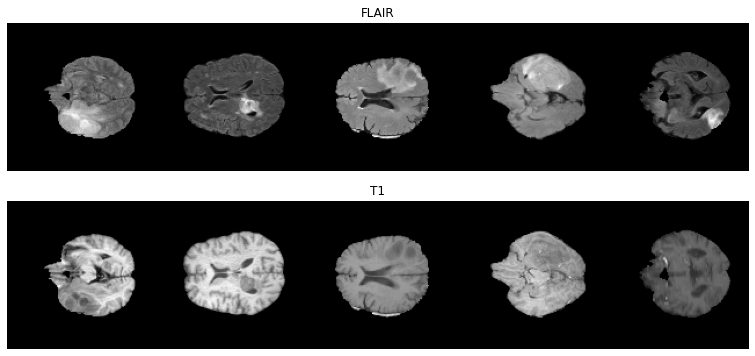

Number of train samples: 300
Number of test samples: 50
Image size: torch.Size([128, 128])
Total shape: torch.Size([300, 1, 128, 128])


In [10]:
# loading brats dataset
train, test = np.load('./data/brats_data.npz'), np.load('./data/brats_data_test.npz')
train_flair, train_t1, test_flair, test_t1 = train['flair'], train['t1'], test['flair'], test['t1']

# turning the data into tensors
train_flair = torch.tensor(train_flair, dtype=torch.float32)
train_t1ce = torch.tensor(train_t1, dtype=torch.float32)
test_flair = torch.tensor(test_flair, dtype=torch.float32)
test_t1ce = torch.tensor(test_t1, dtype=torch.float32)

# resizing images
train_flair = T.functional.resize(train_flair, IMG_SIZE)
test_flair = T.functional.resize(test_flair, IMG_SIZE)
train_t1ce = T.functional.resize(train_t1ce, IMG_SIZE)
test_t1ce = T.functional.resize(test_t1ce, IMG_SIZE)

# preprocessing
n_max_train_flair = [train_flair[i].max() for i in range(train_flair.shape[0])]
n_max_train_t1ce = [train_t1ce[i].max() for i in range(train_t1ce.shape[0])]
n_max_test_flair = [test_flair[i].max() for i in range(test_flair.shape[0])]
n_max_test_t1ce = [test_t1ce[i].max() for i in range(test_t1ce.shape[0])]

for idx in range(0, train_flair.shape[0]):
    train_flair[idx] = (train_flair[idx] / n_max_train_flair[idx])
    train_t1ce[idx] = (train_t1ce[idx] / n_max_train_t1ce[idx])

for idx in range(0, test_flair.shape[0]):
    test_flair[idx] = (test_flair[idx] / n_max_test_flair[idx])
    test_t1ce[idx] = (test_t1ce[idx] / n_max_test_t1ce[idx])

class BraTSDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

# visualizing a sample
n_to_visualize = 5
rand_idx = np.random.randint(0, test_flair.shape[0], n_to_visualize)

plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.imshow(np.hstack([test_flair[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('FLAIR')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(np.hstack([test_t1ce[idx, 0] for idx in rand_idx]), cmap='gray')
plt.title('T1')
plt.axis('off')
plt.show()

print('Number of train samples: {}'.format(train_flair.shape[0]))
print('Number of test samples: {}'.format(test_flair.shape[0]))
print('Image size: {}'.format(train_flair.shape[2:]))
print('Total shape: {}'.format(train_flair.shape))

### Utils

In [11]:
class PolyScheduler(_LRScheduler):
    def __init__(self, optimizer, base_lr, max_steps, warmup_steps, last_epoch=-1):
        self.base_lr = base_lr
        self.warmup_lr_init = 0.0001
        self.max_steps: int = max_steps
        self.warmup_steps: int = warmup_steps
        self.power = 2
        super(PolyScheduler, self).__init__(optimizer, -1, False)
        self.last_epoch = last_epoch

    def get_warmup_lr(self):
        alpha = float(self.last_epoch) / float(self.warmup_steps)
        return [self.base_lr * alpha for _ in self.optimizer.param_groups]

    def get_lr(self):
        if self.last_epoch == -1:
            return [self.warmup_lr_init for _ in self.optimizer.param_groups]
        if self.last_epoch < self.warmup_steps:
            return self.get_warmup_lr()
        else:
            alpha = pow(
                1
                - float(self.last_epoch - self.warmup_steps)
                / float(self.max_steps - self.warmup_steps),
                self.power,
            )
            return [self.base_lr * alpha for _ in self.optimizer.param_groups]

def plot(x, title, n_samples=5, figsize=(10, 2)):    
    plt.figure(figsize=figsize)
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(x[i] if n_samples > 1 else x, cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

def plot_model_stats(model_name, train, test, metric_name, ylim=None, loc='upper right'):
    fig = plt.figure(figsize=(16, 5))
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(train)), train, label = 'Train {}'.format(metric_name))
    plt.plot(np.arange(len(test)), test, label = 'Val {}'.format(metric_name))
    if ylim != None:
        plt.ylim(ylim)
    plt.title('Model: {} - Validation loss: {:.4f}'.format(model_name, test[-1]))
    ax1.set_ylabel(metric_name)
    ax1.set_xlabel("Epochs")
    ax1.legend(loc=loc)
    plt.show()

### Defining architecture

In [14]:
# variational autoencoder
vae = VAE(input_shape=(1, *IMG_SIZE), out_channels=1, latent_dim=64, hidden_channels=[32, 64, 128, 256], skip=False).to(device)

# class CNN for discriminator and classifier
class CNN(nn.Module):
    def __init__(n_classes=1) -> None:
        super().__init__()



In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # 定义编码器
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
        )
        self.encoder_fc1=nn.Linear(32*7*7,nz)
        self.encoder_fc2=nn.Linear(32*7*7,nz)
        self.Sigmoid = nn.Sigmoid()
        self.decoder_fc = nn.Linear(nz+10,32 * 7 * 7)
        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
            nn.Sigmoid(),
        )

    def noise_reparameterize(self,mean,logvar):
        eps = torch.randn(mean.shape).to(device)
        z = mean + eps * torch.exp(logvar)
        return z

    def forward(self, x):
        z = self.encoder(x)
        output = self.decoder(z)
        return output
    def encoder(self,x):
        out1, out2 = self.encoder_conv(x), self.encoder_conv(x)
        mean = self.encoder_fc1(out1.view(out1.shape[0], -1))
        logstd = self.encoder_fc2(out2.view(out2.shape[0], -1))
        z = self.noise_reparameterize(mean, logstd)
        return z,mean,logstd
    def decoder(self,z):
        out3 = self.decoder_fc(z)
        out3 = out3.view(out3.shape[0], 32, 7, 7)
        out3 = self.decoder_deconv(out3)
        return out3

class Discriminator(nn.Module):
    def __init__(self,outputn=1):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 2)),
        )
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, outputn),
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.dis(input)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.squeeze(1)

def loss_function(recon_x, x, mean, logstd):
    # BCE = F.binary_cross_entropy(recon_x,x,reduction='sum')
    MSE = MSECriterion(recon_x,x)
    # 因为var是标准差的自然对数，先求自然对数然后平方转换成方差
    var = torch.pow(torch.exp(logstd), 2)
    KLD = -0.5 * torch.sum(1 + torch.log(var) - torch.pow(mean, 2) - var)
    return MSE + KLD

if __name__ == '__main__':
    dataset = 'cifar10'
    dataset = 'mnist'
    batchSize = 128
    imageSize = 28
    nz=100
    nepoch=20
    if not os.path.exists('./img_CVAE-GAN'):
        os.mkdir('./img_CVAE-GAN')
    print("Random Seed: 88")
    random.seed(88)
    torch.manual_seed(88)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # 可以优化运行效率
    cudnn.benchmark = True
    dataset = dset.MNIST(root='./data',
                         train=True,
                         transform=transforms.Compose([transforms.ToTensor()]),
                         download=True
                         )
    n_channel = 1
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batchSize,
                                             shuffle=True)

    print("=====> 构建VAE")
    vae = VAE().to(device)
    vae.load_state_dict(torch.load('./CVAE-GAN-VAE.pth'))
    print("=====> 构建D")
    D = Discriminator(1).to(device)
    D.load_state_dict(torch.load('./CVAE-GAN-Discriminator.pth'))
    print("=====> 构建C")
    C = Discriminator(10).to(device)
    C.load_state_dict(torch.load('./CVAE-GAN-Classifier.pth'))
    criterion = nn.BCELoss().to(device)
    MSECriterion = nn.MSELoss().to(device)

    print("=====> Setup optimizer")
    optimizerD = optim.Adam(D.parameters(), lr=0.0001)
    optimizerC = optim.Adam(C.parameters(), lr=0.0001)
    optimizerVAE = optim.Adam(vae.parameters(), lr=0.0001)

    for epoch in range(nepoch):
        for i, (data,label) in enumerate(dataloader, 0):
            # 先处理一下数据
            data = data.to(device)
            label_onehot = torch.zeros((data.shape[0], 10)).to(device)
            label_onehot[torch.arange(data.shape[0]), label] = 1
            batch_size = data.shape[0]
            # 先训练C
            output = C(data)
            real_label = label_onehot.to(device)  # 定义真实的图片label为1
            errC = criterion(output, real_label)
            C.zero_grad()
            errC.backward()
            optimizerC.step()
            # 再训练D
            output = D(data)
            real_label = torch.ones(batch_size).to(device)   # 定义真实的图片label为1
            fake_label = torch.zeros(batch_size).to(device)  # 定义假的图片的label为0
            errD_real = criterion(output, real_label)

            z = torch.randn(batch_size, nz + 10).to(device)
            fake_data = vae.decoder(z)
            output = D(fake_data)
            errD_fake = criterion(output, fake_label)

            errD = errD_real+errD_fake
            D.zero_grad()
            errD.backward()
            optimizerD.step()
            # 更新VAE(G)1
            z,mean,logstd = vae.encoder(data)
            z = torch.cat([z,label_onehot],1)
            recon_data = vae.decoder(z)
            vae_loss1 = loss_function(recon_data,data,mean,logstd)
            # 更新VAE(G)2
            output = D(recon_data)
            real_label = torch.ones(batch_size).to(device)
            vae_loss2 = criterion(output,real_label)
            # 更新VAE(G)3
            output = C(recon_data)
            real_label = label_onehot
            vae_loss3 = criterion(output, real_label)

            vae.zero_grad()
            vae_loss = vae_loss1+vae_loss2+vae_loss3
            vae_loss.backward()
            optimizerVAE.step()
            if i%100==0:
                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_C: %.4f Loss_G: %.4f'
                      % (epoch, nepoch, i, len(dataloader),
                         errD.item(),errC.item(),vae_loss.item()))
            if epoch==0:
                real_images = make_grid(data.cpu(), nrow=8, normalize=True).detach()
                save_image(real_images, './img_CVAE-GAN/real_images.png')
            if i == len(dataloader)-1:
                sample = torch.randn(data.shape[0], nz).to(device)
                print(label)
                sample = torch.cat([sample,real_label],1)
                output = vae.decoder(sample)
                fake_images = make_grid(output.cpu(), nrow=8, normalize=True).detach()
                save_image(fake_images, './img_CVAE-GAN/fake_images-{}.png'.format(epoch + 26))